# OSIC: keras model training on images and tabular data

Here is an awkward attempt to develop a model which utilizes both images and tabular data. The main idea came from [this article](https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/):

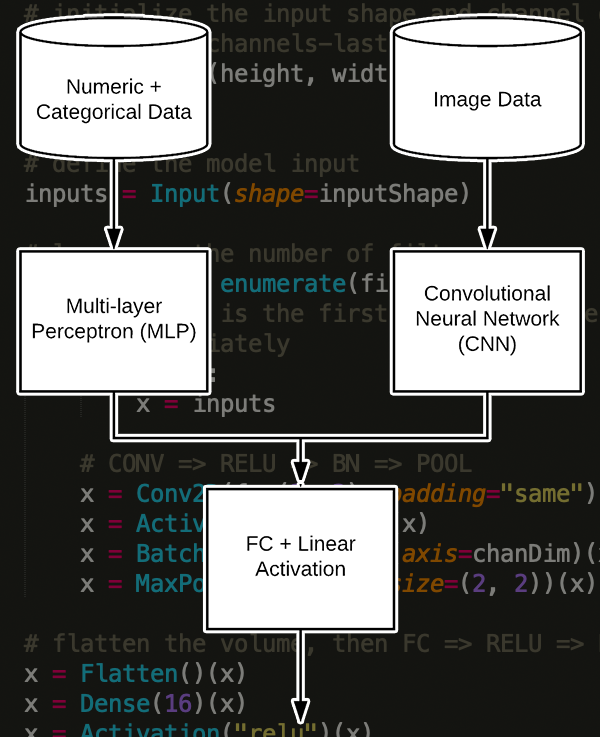

This notebook is partialy based on [Osic-Multiple-Quantile-Regression-Starter](https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter) to deal with tabular data.

[EfficientNet](https://github.com/qubvel/efficientnet) is used as backbone to create features from images.

Here is [a model inference notebook](https://www.kaggle.com/vgarshin/osic-keras-images-and-tabular-data-inference).

## Import libraries

In [ ]:
%%time
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index
!conda install -c conda-forge -y gdcm

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import os
import cv2
import random
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import efficientnet.tfkeras as efn
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import pydicom
print('tensorflow version:', tf.__version__)

In [ ]:
def seed_all(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_all(2020)
DATA_PATH = '../input/osic-pulmonary-fibrosis-progression'
BATCH_SIZE = 10
FEATURES = True
N_FOLDS = 4
ADV_FEATURES = False
C_SIGMA, C_DELTA = tf.constant(70, dtype='float32'), tf.constant(1000, dtype='float32')
QS = [.05, .50, .95]
IMG_SIZE = 224
RESIZE = 224
SEQ_LEN = 12
CUTOFF = 2
LAMBDA = .8
MDL_VERSION = 'v5'
MODELS_PATH = '.'
MASKED = False
DECAY = False

## Load tabular data and create new features

In [ ]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
test = pd.read_csv(f'{DATA_PATH}/test.csv')
subm = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
subm['Patient'] = subm['Patient_Week'].apply(lambda x: x.split('_')[0])
subm['Weeks'] = subm['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
subm =  subm[['Patient','Weeks','Confidence','Patient_Week']]
subm = subm.merge(test.drop('Weeks', axis=1), on='Patient')
train['SPLIT'] = 'train'
test['SPLIT'] = 'val'
subm['SPLIT'] = 'test'
data = train.append([test, subm])
print('train:',  train.shape, 'unique Pats:', train.Patient.nunique(),
      '\ntest:', test.shape,  'unique Pats:', test.Patient.nunique(),
      '\nsubm:', subm.shape,  'unique Pats:', subm.Patient.nunique(),
      '\ndata',  data.shape,  'unique Pats:', data.Patient.nunique())
data['min_week'] = data['Weeks']
data.loc[data.SPLIT == 'test', 'min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [ ]:
data = pd.concat([data, pd.get_dummies(data.Sex), pd.get_dummies(data.SmokingStatus)], axis=1)
if FEATURES:
    base = data.loc[data.Weeks == data.min_week]
    base = base[['Patient', 'FVC']].copy()
    base.columns = ['Patient', 'min_week_FVC']
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    base = base[base.nb == 1]
    base.drop('nb', axis=1, inplace=True)
    data = data.merge(base, on='Patient', how='left')
    data['relative_week'] = data['Weeks'] - data['min_week']
    del base
if ADV_FEATURES:
    target_cols = ['FVC']
    enc_cols =  [ 
        'Female',
        'Male',
        'Currently smokes',
        'Ex-smoker',
        'Never smoked'
    ]
    for t_col in target_cols:
        for col in enc_cols:
            col_name = f'_{col}_{t_col}_'
            data[f'enc{col_name}mean'] = data.groupby(col)[t_col].transform('mean')
            data[f'enc{col_name}std'] = data.groupby(col)[t_col].transform('std')
    data['TC'] = 0
    data.loc[data['Weeks'] == 0, 'TC'] = 1
print(data.shape)
print(data.columns)

In [ ]:
feat_cols = [
    'Female', 'Male',
    'Currently smokes', 
    'Ex-smoker', 'Never smoked'
]
scale_cols = [
    'Percent', 
    'Age', 
    'relative_week', 
    'min_week_FVC'
]
scale_cols.extend([x for x in data.columns if 'FVC_mean' in x])
scale_cols.extend([x for x in data.columns if 'FVC_std' in x])
scaler = MinMaxScaler()
data[scale_cols] = scaler.fit_transform(data[scale_cols])
feat_cols.extend(scale_cols)
train = data.loc[data.SPLIT == 'train']
test = data.loc[data.SPLIT == 'val']
subm = data.loc[data.SPLIT == 'test']
del data
print(feat_cols)
train.head()

## Data Generator to load CT scans

Data generator provides a batch with images sequences (sequence of CT images) with tabular data for patients in batch. We need ordered CT scans in order to simulate 3D analysis of images, outputs of neural network's bottleneck are concateneted with tabular data and feeded to head with dense layers to obtain quantile regression model:

In [ ]:
class DataGenOsic(Sequence):
    def __init__(self, df, tab_cols,
                 batch_size=8, mode='fit', shuffle=False, 
                 aug=None, resize=None, masked=True, cutoff=2,
                 seq_len=12, img_size=224):
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.resize = resize
        self.masked = masked
        self.cutoff = cutoff
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.tab_cols = tab_cols
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        batch_size = min(self.batch_size, len(self.df) - index * self.batch_size)
        X_img = np.zeros((batch_size, self.seq_len, self.img_size, self.img_size, 3), dtype=np.float32)
        X_tab = self.df[index * self.batch_size : (index + 1) * self.batch_size][self.tab_cols].values
        pats_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['Patient'].values
        for i, pat_id in enumerate(pats_batch):
            imgs_seq = self.get_imgs_seq(pat_id)
            X_img[i, ] = imgs_seq
        if self.mode == 'fit':
            y = np.array(
                self.df[index * self.batch_size : (index + 1) * self.batch_size]['FVC'].values, 
                dtype=np.float32
            )
            return (X_img, X_tab), y
        elif self.mode == 'predict':
            y = np.zeros(batch_size, dtype=np.float32)
            return (X_img, X_tab), y
        else:
            raise AttributeError('mode parameter error')
    def load_scan(self, pat_id):
        if self.mode == 'fit':
            path = f'{DATA_PATH}/train/{pat_id}'
        elif self.mode == 'predict':
            path = f'{DATA_PATH}/test/{pat_id}'
        else:
            raise AttributeError('mode parameter error')
        file_names = sorted(os.listdir(path), key=lambda x: int(os.path.splitext(x)[0]))
        idxs = [
            int(i * len(file_names) / (self.seq_len + 2 * self.cutoff)) 
            for i in range(self.seq_len + 2 * self.cutoff)
        ]
        slices = [
            pydicom.read_file(path + '/' + file_names[idx])
            for idx in idxs[self.cutoff:-self.cutoff]
        ]
        if len(slices) < self.seq_len:
            for i in range(self.seq_len - len(slices)):
                slices.append(
                    pydicom.read_file(path + '/' + os.listdir(path)[-1])
                )
        return slices
    def get_pixels_hu(self, scans):
        image = np.stack([s.pixel_array.astype(float) for s in scans])
        image = image.astype(np.int16)
        image[image == -2000] = 0
        intercept = scans[0].RescaleIntercept
        slope = scans[0].RescaleSlope
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        image += np.int16(intercept)
        return np.array(image, dtype=np.int16)
    def get_imgs_seq(self, pat_id):
        seq_imgs = []
        slices = self.load_scan(pat_id)
        scans = self.get_pixels_hu(slices)
        for img_idx in range(self.seq_len):
            img = scans[img_idx]
            if self.masked:
                mask = self.get_lungs_mask(img)
                img[mask == False] = img.min()
            if self.resize:
                img = cv2.resize(img, (self.resize, self.resize))
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = np.repeat(img[..., np.newaxis], 3, -1)
            seq_imgs.append(img)                 
        return np.array(seq_imgs).astype(np.float32)
    def get_lungs_mask(self, img):
        mask = img < -200
        mask = clear_border(mask)
        mask = label(mask)
        areas = [r.area for r in regionprops(mask)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(mask):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        mask[coordinates[0], coordinates[1]] = 0
        return mask > 0

In [ ]:
gkf = GroupKFold(n_splits=N_FOLDS)
train['fold'] = -1
for i, (train_idx, val_idx) in enumerate(gkf.split(train, groups=train['Patient'])):
    train.loc[val_idx, 'fold'] = i

In [ ]:
train_datagen = DataGenOsic(
    df=train.loc[train['fold'] != 0], 
    tab_cols=feat_cols,
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=None, 
    resize=RESIZE,
    masked=MASKED,
    cutoff=CUTOFF,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE
)
val_datagen = DataGenOsic(
    df=train.loc[train['fold'] == 0],
    tab_cols=feat_cols,
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None,
    resize=RESIZE,
    masked=MASKED,
    cutoff=CUTOFF,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE
)

Visualization of a single batch:

In [ ]:
(Xt_img, Xt_tab), yt = val_datagen.__getitem__(0)
print('test X img: ', Xt_img.shape)
print('test X tab: ', Xt_tab.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(10, 8), nrows=BATCH_SIZE, ncols=SEQ_LEN)
for j in range(BATCH_SIZE):
    for i in range(SEQ_LEN):
        axes[j, i].imshow(Xt_img[j][i])
        axes[j, i].axis('off')
        axes[j, i].set_title(yt[j])
plt.show()
print(yt)

## Train model

In [ ]:
def metric(y_true, y_pred, pred_std):
    clip_std = np.clip(pred_std, 70, 9e9)  
    delta = np.clip(np.abs(y_true - y_pred), 0 , 1000)  
    return np.mean(-1 * (np.sqrt(2) * delta / clip_std) - np.log(np.sqrt(2) * clip_std))
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = (y_pred[:, 2] - y_pred[:, 0]) / 2
    fvc_pred = y_pred[:, 1]
    sigma_clip = tf.maximum(sigma, C_SIGMA)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C_DELTA)
    sq2 = tf.sqrt(tf.dtypes.cast(2, dtype=tf.float32))
    metric = sq2 * (delta / sigma_clip) + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)
def qloss(y_true, y_pred):
    q = tf.constant(np.array([QS]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q - 1) * e)
    return K.mean(v)
def mloss(lmbd):
    def loss(y_true, y_pred):
        return lmbd * qloss(y_true, y_pred) + (1 - lmbd) * score(y_true, y_pred)
    return loss
def get_lr_callback(batch_size=10, epochs=100, warmup=.3, plot=False):
    lr_start = 0.0001
    lr_max = 0.001 * batch_size
    lr_min = 0.00001
    lr_ramp_ep = epochs * warmup
    lr_sus_ep = 0
    lr_decay = 0.97
    def lr_scheduler(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max
            else:
                lr = (lr_max - lr_min) * lr_decay ** (epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            return lr
    if plot == False:
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=False)
        return lr_callback 
    else: 
        return lr_scheduler
class LogPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_score = []        
    def on_epoch_end(self, epoch, logs=None):
        self.val_score.append(logs['val_score'])
        if epoch % 5 == 0 or epoch == (EPOCHS - 1):
            print(
                f"\tEPOCH {epoch + 1} | loss: {logs['loss']:.2f} | score: {logs['score']}",
                f"| val loss: {logs['val_loss']:.2f} | val score: {logs['val_score']}"
            )
    def on_train_end(self, lowest_val_loss, logs=None):
        best_epoch = np.argmin(self.val_score)
        best_score = self.val_score[best_epoch]
        print(f'best model at epoch {best_epoch + 1} | score: {best_score}')
def get_model(inputs_seq_shape, inputs_tab_shape, units=128, mult=2, prob=.4, lmbd=.8):
    bottleneck = efn.EfficientNetB0(
        weights='../input/effnetweights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5', 
        include_top=False, 
        pooling='avg'
    )
    bottleneck = M.Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
    inputs_seq = L.Input(shape=(*inputs_seq_shape, ))
    inputs_tab = L.Input(shape=(inputs_tab_shape, ))
    x = L.TimeDistributed(bottleneck)(inputs_seq) 
    x = L.TimeDistributed(L.BatchNormalization())(x)
    x = L.GlobalMaxPooling3D()(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(prob)(x)
    x = L.Dense(int(mult * units), activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(prob)(x)
    comb_inputs = L.concatenate([inputs_tab, x]) # concatenate features from EfficientNet network and tabular data
    x = L.Dense(units, activation='relu')(comb_inputs)
    x = L.Dropout(prob)(x)
    x = L.Dense(units, activation='relu')(x)
    x = L.Dropout(prob)(x)
    preds = L.Dense(3, activation='linear')(x)
    model = M.Model([inputs_seq, inputs_tab], preds)
    model.compile(
        loss=mloss(lmbd),
        optimizer=Adam(lr=0.01), 
        metrics=[score]
    )
    return model

In [ ]:
EPOCHS = 400
model_file = f'{MODELS_PATH}/model_{MDL_VERSION}.h5'
earlystopper = EarlyStopping(
        monitor='val_score', 
        patience=20, 
        verbose=0,
        mode='min'
        )
modelsaver = ModelCheckpoint(
    model_file, 
    monitor='val_score', 
    verbose=1, 
    save_best_only=True,
    mode='min'
)
lrreducer = ReduceLROnPlateau(
    monitor='val_score',
    factor=.1,
    patience=10,
    verbose=0,
    min_lr=1e-5,
    mode='min'
)
callbacks = [earlystopper, modelsaver, LogPrintingCallback()]
if DECAY:
    lr_scheduler_plot = get_lr_callback(batch_size=10, plot=True)
    xs = [i for i in range(EPOCHS)]
    y = [lr_scheduler_plot(x) for x in xs]
    plt.plot(xs, y)
    plt.title(f"lr schedule from {y[0]:.3f} to {max(y):.3f} to {y[-1]:.5f}")
    plt.show()
    callbacks.append(get_lr_callback(BATCH_SIZE))
else:
    callbacks.append(lrreducer)

In [ ]:
%%time
model = get_model(
    inputs_seq_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3), 
    inputs_tab_shape=len(feat_cols), 
    units=128, mult=4, prob=0, lmbd=LAMBDA
)
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    verbose=1
)

In [ ]:
history_file = f'{MODELS_PATH}/history_{MDL_VERSION}.txt'
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['score'][:ep_max], label='score')
plt.plot(history.history['val_score'][:ep_max], label='val score')
plt.legend()
plt.show()

**TODO:**
1. Inference part => Done [here](https://www.kaggle.com/vgarshin/osic-keras-images-and-tabular-data-inference)
2. Understand if there is a profit from this stuff